# Image Recognition with a Multi-hidden Layer with Tensorflow

> This project uses a Multi-hidden layer Neural Network for multiclass image classification. The neural network used is programmed using Tensorflow. The data is taken from Kaggle.The data consists of 48x48 pixel grayscale images of faces. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The relevant URL is:https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge The utils file contains all the necessary function that will be used such as activation functions(relu,tanh), indicator matrix function etc. In this project we use backpropagation to allow the neural network to be trained. In order the Neural Network to operate faster RMSPropOptimizer is used.

## Imports

In [2]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils2 import getData, getBinaryData, indicator_mat_conv, error_rate_mean, init_weight_and_bias
from sklearn.utils import shuffle

0: 4953 1: 547 2: 5121 3: 8989 4: 6077 5: 4002 6: 6198 7: 0 8: 0 9: 35887


## A Hidden Layer Class

> The hidden layer class initialises a hidden layer class with three attributes, input layer with M1 number of features, M2 number of output features and an id. It has one method, forward, which performs matrix multiplication and passes it to a tensorflow activation function,in this case relu.

In [1]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)

## A Neural Network Class

> This is the main class in this project and it takes one attribute - hidden layer sizes.
It contains a fit method contains most of functionality including: spitting the data into training and validataion(testing) sets, hidden layer initialisation, setting up the neural network cost by using softmax_cross_entropy_with_logits, setting up a tensorflow session and calling the RMSPropOptimiser to perform the backpropagation. This effectivelly substitutes all the derivatives equations from the project Neural Network for Binary Classification. It also defines two more methods - forward which performs matrix multiplication between the input data X and the weights and biasses which is used in cost calculation and prediction which uses argmax to obtain the index of the predicted class. The learning rate is set to 1e-2, the momentum has a value of 0.99, regularisation parameter has a value of 1e-3 and the batch size is of value 100. For convenience the batch size is set to 10 in order to speed up the calculation. 

In [3]:
class NNet(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=1e-2, mu=0.99, decay=0.999, reg=1e-3, epochs=10, batch_sz=100, show_fig=False):
        K = len(set(Y))# K contains all the classes that we are trying to predict.

        # Spliting the data into training and validation sets
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = indicator_mat_conv(Y).astype(np.float32)#performs one hot encoding on labels
        # Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]#1000 samples for validation(testing) the rest are reserved for learning
        Yvalid_flat = np.argmax(Yvalid, axis=1) 
        X, Y = X[:-1000], Y[:-1000]

        # initialize hidden layers
        N, D = X.shape
        
        self.hidden_layers = []
        M1 = D
        count = 0
        #Initialise each hidden layer. The assignment statement M1=M2 is due to the fact that the output of each previous hidden
        #layer becomes input to the next hidden layer
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        #Defining the W and b as tensorflow variables of type float32
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        # The parameters stored in self.params will be used later
        
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # Setting up tensorflow placeholders for the data
        # The act variable is passed as a parameter to softmax_cross_entropy_with_logits when the cost is 
        #calculated.
        
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=act,
                labels=tfT
            )
        ) + rcost
        prediction = self.predict(tfX)
        # Using RMSPropOptimizer to minimise the cost. It effectivelly performs gradient descent with some optimisations to 
        #make it calculate faster.
        
        train_op = tf.train.RMSPropOptimizer(learning_rate, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz#setting up the batches 
        costs = []
        init = tf.global_variables_initializer()
        
        #starting up a session
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})

                    if j % 20 == 0:
                        #Will be printing each 20th sample of each batch
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        e = error_rate_mean(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    #Defining the forward and predict methods
    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b
    # Performs the actual prediction i.e classifies the output.
    def predict(self, X):
        act = self.forward(X)
        return tf.argmax(act, 1)

## Class Initialisation

> Here the main class will be initialised. The neural network is initialised with three hidden layers as stated above with sizes of 2000,1000 and 500 units respectivelly. 

i: 0 j: 0 nb: 348 cost: 3.69076 error rate: 0.837
i: 0 j: 20 nb: 348 cost: 3.57621 error rate: 0.817
i: 0 j: 40 nb: 348 cost: 3.49857 error rate: 0.724
i: 0 j: 60 nb: 348 cost: 3.47054 error rate: 0.724
i: 0 j: 80 nb: 348 cost: 3.43008 error rate: 0.724
i: 0 j: 100 nb: 348 cost: 3.37122 error rate: 0.708
i: 0 j: 120 nb: 348 cost: 3.34308 error rate: 0.684
i: 0 j: 140 nb: 348 cost: 3.24996 error rate: 0.67
i: 0 j: 160 nb: 348 cost: 3.25777 error rate: 0.716
i: 0 j: 180 nb: 348 cost: 3.16058 error rate: 0.678
i: 0 j: 200 nb: 348 cost: 3.07922 error rate: 0.671
i: 0 j: 220 nb: 348 cost: 3.05901 error rate: 0.669
i: 0 j: 240 nb: 348 cost: 3.02296 error rate: 0.688
i: 0 j: 260 nb: 348 cost: 2.99217 error rate: 0.701
i: 0 j: 280 nb: 348 cost: 2.92335 error rate: 0.675
i: 0 j: 300 nb: 348 cost: 2.86585 error rate: 0.702
i: 0 j: 320 nb: 348 cost: 2.79299 error rate: 0.673
i: 0 j: 340 nb: 348 cost: 2.8155 error rate: 0.717
i: 1 j: 0 nb: 348 cost: 2.73725 error rate: 0.674
i: 1 j: 20 nb: 348 cos

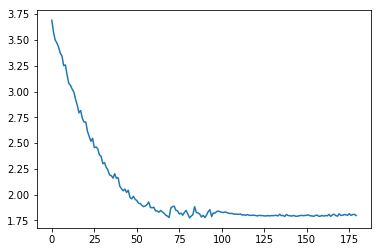

In [4]:
def main():
    X, Y = getData()
    # X, Y = getBinaryData()
    model = NNet([2000, 1000, 500])
    model.fit(X, Y, show_fig=True)

if __name__ == '__main__':
    main()